In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, 
    classification_report, 
    confusion_matrix,
    roc_curve
)
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


In [2]:
df = pd.read_csv("../data/processed/baseline.csv")

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
models = {}

# Logistic
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train_scaled, y_train)
models["Logistic"] = (lr, X_test_scaled)

# Random Forest
rf = RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
models["Random Forest"] = (rf, X_test)

# XGBoost
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    eval_metric="logloss",
    random_state=42
)
xgb_model.fit(X_train, y_train)
models["XGBoost"] = (xgb_model, X_test)

# SGD
sgd = SGDClassifier(loss="log_loss", class_weight="balanced", random_state=42)
sgd.fit(X_train_scaled, y_train)
models["SGD"] = (sgd, X_test_scaled)


In [4]:
auc_scores = {}

for name, (model, X_eval) in models.items():
    probs = model.predict_proba(X_eval)[:, 1]
    auc = roc_auc_score(y_test, probs)
    auc_scores[name] = auc

pd.Series(auc_scores)

Logistic         0.964715
Random Forest    0.956986
XGBoost          0.949981
SGD              0.969019
dtype: float64

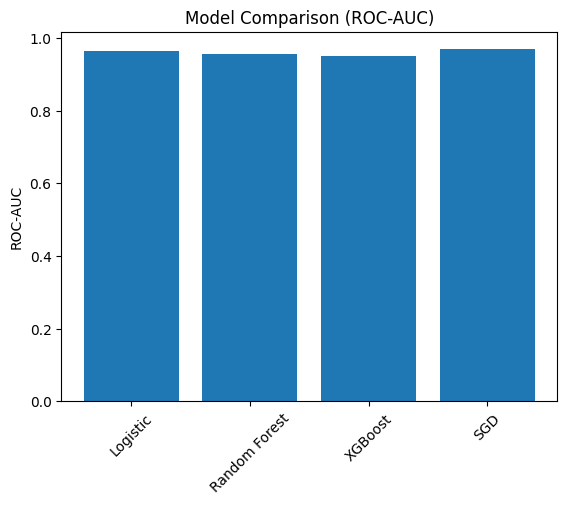

In [5]:
plt.figure()
plt.bar(auc_scores.keys(), auc_scores.values())
plt.xticks(rotation=45)
plt.ylabel("ROC-AUC")
plt.title("Model Comparison (ROC-AUC)")
plt.show()


In [8]:
from sklearn.metrics import classification_report, roc_auc_score

for name, (model, X_eval) in models.items():
    
    print(f"\n📌 Model: {name}")
    
    # Predictions
    preds = model.predict(X_eval)
    probs = model.predict_proba(X_eval)[:, 1]
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, preds))
    
    # ROC-AUC
    auc = roc_auc_score(y_test, probs)
    print(f"ROC-AUC: {auc:.4f}")



📌 Model: Logistic

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     22737
           1       0.08      0.92      0.14        48

    accuracy                           0.98     22785
   macro avg       0.54      0.95      0.57     22785
weighted avg       1.00      0.98      0.99     22785

ROC-AUC: 0.9647

📌 Model: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22737
           1       0.93      0.81      0.87        48

    accuracy                           1.00     22785
   macro avg       0.96      0.91      0.93     22785
weighted avg       1.00      1.00      1.00     22785

ROC-AUC: 0.9570

📌 Model: XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22737
           1       0.91      0.83      0.87        48

    accuracy     

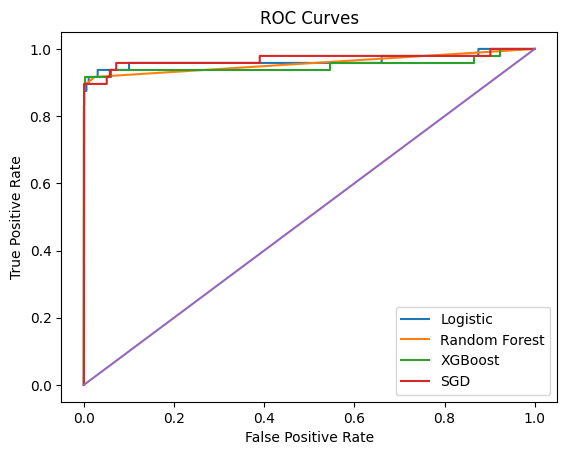

In [6]:
plt.figure()

for name, (model, X_eval) in models.items():
    probs = model.predict_proba(X_eval)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1], [0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


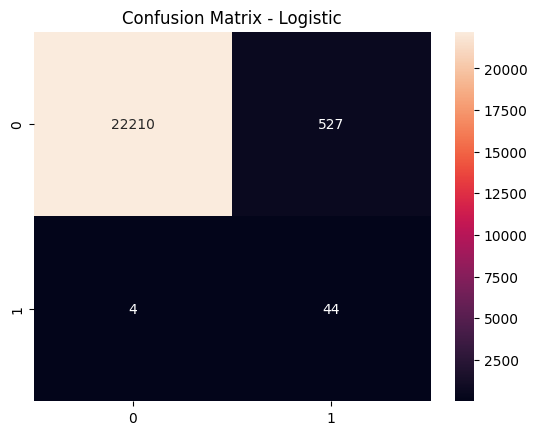

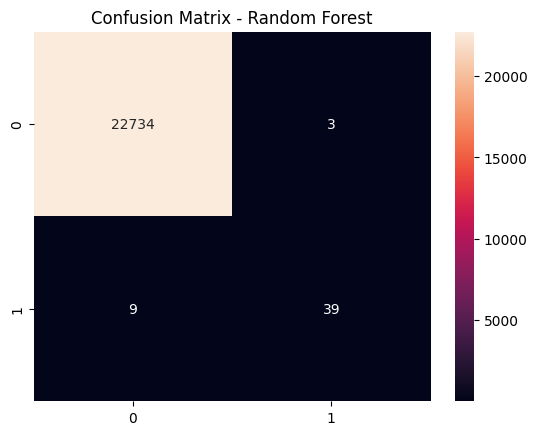

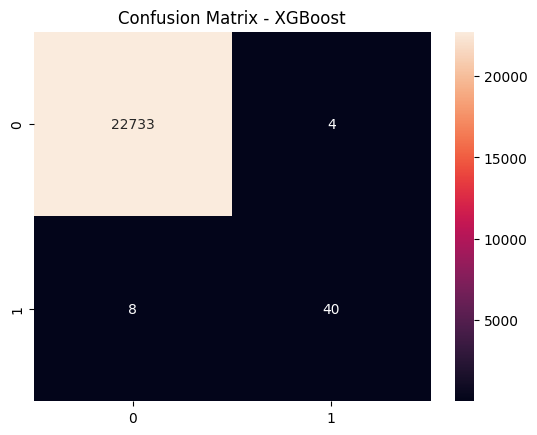

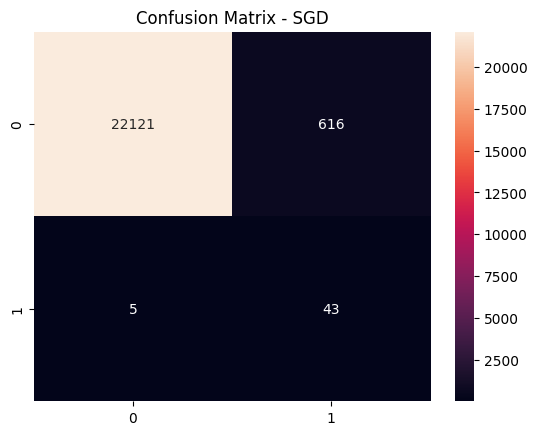

In [7]:
for name, (model, X_eval) in models.items():
    preds = model.predict(X_eval)
    cm = confusion_matrix(y_test, preds)
    
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
